In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from joblib import Parallel, delayed

np.set_printoptions(suppress=True, precision=6)
pd.set_option('display.float_format', '{:.6f}'.format)

2023-09-26 18:19:40.679081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 18:19:41.313099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("data/otu_table_example.csv", index_col="Unnamed: 0").T

In [3]:
print(df.head())

             1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8        0        0        0        0        0        0        0   
E000823.2.6        0        0        0        0        0        0        0   
E000823.4.0        0        0        0        0        0        0        0   
E000823.5.0        0        0        0        0        0        0        0   
E000823.5.7        0        0        0        0        0        0        0   

             4327628  326749   183857   ...  317924   4294457  2655741  \
E000823.1.8        0        0        0  ...        0        0        0   
E000823.2.6        0        0        0  ...        0        0        0   
E000823.4.0        0        0        0  ...        0        0        0   
E000823.5.0        0        0        0  ...        0        0        0   
E000823.5.7        0        0        0  ...        0        0        0   

             858535   186092   299820   225846   4306049  366846   1124370  
E000823.1

In [4]:
# get rid of features that are way too sparse
zero_values_percentage_cutoff = .8

zero_counts = pd.Series([sum(df[col] == 0) for col in df.columns], index=df.columns)
zero_pcts = zero_counts / len(df)
populated_feats = zero_pcts[zero_pcts < zero_values_percentage_cutoff].index
df = df[populated_feats]

In [5]:
df

,189592,183857,4343580,177319,194104,362389,1142029,199301,659361,364179,...,364563,583117,179423,823634,356360,365385,580008,296945,267718,354850
E000823.1.8,0,0,2,0,0,0,0,0,0,0,...,0,65,0,0,0,1,0,0,0,7
E000823.2.6,0,0,1,0,0,0,2,0,0,4,...,0,90,0,0,0,1,0,0,0,2
E000823.4.0,0,0,0,0,0,0,0,0,0,4,...,0,170,0,0,0,4,0,0,0,4
E000823.5.0,0,0,0,0,0,0,0,0,0,0,...,0,85,0,0,0,2,0,0,0,0
E000823.5.7,0,0,0,0,0,0,1,0,0,5,...,0,55,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,1,0,4,13,6,1,0,27,101,2117,...,1,5003,0,8,0,1,446,0,5,7
E014086.32.4,0,0,0,44,16,0,0,50,33,2520,...,7,10760,2,10,4,0,851,0,3,50
E014086.33.5,0,0,3,11,11,0,0,39,3,2447,...,2,8449,0,0,3,0,664,0,3,46
E014086.34.4,1,0,1,9,9,0,0,20,20,1402,...,2,4769,0,0,1,0,180,0,3,28


In [6]:
def forward_rolling_average(series, window_size):
    
    original_idxs = series.index
    
    series = series.reset_index(drop=True)
    
    for idx in range(len(series) - window_size):
       
        next_vals = series[idx:idx+window_size]
        
        #print(idx, next_vals.tolist())
        #print(next_vals.mean())
        
        series[idx] = next_vals.mean()
    
    series.index = original_idxs
    
    series = series.iloc[:-window_size]
            
    return series
    

In [7]:
#window_size = 3
#sequence = pd.Series([0,1,2,3,4,5,6,7,8,9,10])

#forward_rolling_average(sequence, window_size).tolist()
# out [1, 2, 3, 4, 5, 6, 7, 8]

In [8]:
#def smooth_it_out(df, rolling_window=5):
#    # Define the window size for the rolling average
#    window_size = 5
#    
#    # Apply rolling mean to numeric columns
#    df = df.shift(-window_size + 1).rolling(window=window_size).mean()
#    
#    return df

In [9]:
def smooth_it_out(df, window_size=5, n_jobs=32):
    
    smooth_cols = Parallel(n_jobs=n_jobs)(delayed(forward_rolling_average)(df[col], window_size) for col in df.columns)
    
    for idx, col in enumerate(df.columns):
        df[col] = smooth_cols[idx]
        
    df = df.iloc[:-window_size]
    
    return df

In [10]:
def feature_wise_scaling(df):
    for col in df.columns:
        _min_ = df[col].min()
        _max_ = df[col].max()
        
        df[col] = (df[col] - _min_) / (_max_ - _min_)
        
    return df      

In [11]:
def preprocess(feats_df, seq_length):
    num_features = len(feats_df.columns)
    
    X_sequences = []
    y_targets = []
    
    for i in range(len(feats_df) - seq_length):
        X_sequences.append(feats_df.iloc[i:i+seq_length])
        y_targets.append(feats_df.iloc[i+seq_length])
    
    X_sequences = np.array(X_sequences)
    y_targets = np.array(y_targets)
    
    X_sequences = X_sequences.reshape(-1, seq_length, num_features)
    
    return X_sequences, y_targets

In [12]:
def mae_ignore_zeros(y_true, y_pred, false_positives_penalty_factor=0.1):
    
    # Find indices where y_true is not zero
    non_zero_indices = tf.where(tf.not_equal(y_true, 0))
    
    # Gather the non-zero elements from y_true and y_pred using the indices
    y_true_non_zero = tf.gather_nd(y_true, non_zero_indices)
    y_pred_non_zero = tf.gather_nd(y_pred, non_zero_indices)
    
    y_true_non_zero = tf.cast(y_true_non_zero, tf.float64)
    y_pred_non_zero = tf.cast(y_pred_non_zero, tf.float64)
    
    # Calculate MAE on the non-zero elements
    mae_non_zero = tf.reduce_mean(tf.abs(y_pred_non_zero - y_true_non_zero))
    
    # Find indices where y_true is zero 
    zero_indices = tf.where(tf.equal(y_true, 0))
    
    # Gather the corresponding y_pred values
    y_pred_zero = tf.gather_nd(y_pred, zero_indices)
    
    y_pred_zero = tf.cast(y_pred_zero, tf.float64)
    
    # Calculate the average of false positives
    false_positives_avg = tf.reduce_mean(y_pred_zero)
    
    # Combine the MAE on non-zero elements with the average of false positives
    mae_ignore_zeros = mae_non_zero + (false_positives_avg * false_positives_penalty_factor)
    
    return mae_ignore_zeros

In [13]:
y_true = [0,0,10]
y_pred = [0,0,0]

keras.losses.mae(y_true, y_pred)

2023-09-26 18:19:43.203124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 18:19:43.219683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 18:19:43.219970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [14]:
mae_ignore_zeros(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=10.0>

In [15]:
df = smooth_it_out(df=df, window_size=5)
df

,189592,183857,4343580,177319,194104,362389,1142029,199301,659361,364179,...,364563,583117,179423,823634,356360,365385,580008,296945,267718,354850
E000823.1.8,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,2.600000,...,0.000000,93.000000,0.000000,0.000000,0.000000,1.600000,0.000000,0.000000,0.000000,2.600000
E000823.2.6,0.000000,0.200000,0.200000,0.000000,0.000000,0.400000,1.400000,0.000000,34.800000,3.200000,...,0.000000,91.000000,0.800000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.200000
E000823.4.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.400000,3.200000,0.000000,34.800000,3.000000,...,0.000000,290.000000,0.800000,0.000000,0.000000,1.800000,0.000000,0.000000,0.000000,0.800000
E000823.5.0,0.000000,0.400000,0.200000,0.000000,0.000000,0.400000,3.400000,0.000000,34.800000,2.400000,...,0.000000,270.600000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
E000823.5.7,0.200000,0.600000,0.200000,2.600000,8.400000,1.000000,3.400000,0.600000,34.800000,2.400000,...,0.000000,735.800000,1.400000,0.000000,0.000000,13.800000,0.000000,0.000000,0.000000,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,1.200000,0.000000,1.600000,3.200000,8.000000,0.000000,0.000000,24.000000,35.600000,1354.200000,...,0.200000,2899.000000,0.200000,12.000000,0.600000,29.200000,397.600000,0.000000,8.200000,17.400000
E014086.23.4,1.400000,0.000000,2.400000,5.200000,7.800000,0.200000,0.000000,27.600000,55.800000,1703.800000,...,0.400000,3600.600000,0.200000,12.600000,0.400000,29.400000,486.800000,0.000000,8.800000,12.600000
E014086.24.5,1.400000,0.000000,1.400000,13.800000,11.000000,0.200000,0.000000,36.400000,62.400000,1898.000000,...,1.800000,5270.800000,0.600000,14.600000,1.200000,29.400000,657.000000,0.000000,9.400000,19.600000
E014086.26.4,0.200000,0.000000,2.000000,15.600000,10.200000,0.200000,0.000000,36.200000,39.200000,1801.600000,...,2.200000,6550.400000,0.400000,12.400000,1.800000,0.200000,673.800000,0.000000,6.200000,22.000000


In [16]:
df = feature_wise_scaling(df)
df

/tmp/ipykernel_2456974/2433063030.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col] - _min_) / (_max_ - _min_)


,189592,183857,4343580,177319,194104,362389,1142029,199301,659361,364179,...,364563,583117,179423,823634,356360,365385,580008,296945,267718,354850
E000823.1.8,0.000000,0.000000,0.085714,0.000000,0.000000,0.000000,0.015789,0.000000,0.000000,0.000221,...,0.000000,0.010525,0.000000,0.000000,0.000000,0.000678,0.000000,0.000000,0.000000,0.043189
E000823.2.6,0.000000,0.055556,0.028571,0.000000,0.000000,0.048780,0.036842,0.000000,0.052888,0.000273,...,0.000000,0.010298,0.038835,0.000000,0.000000,0.000848,0.000000,0.000000,0.000000,0.019934
E000823.4.0,0.000000,0.055556,0.000000,0.000000,0.000000,0.048780,0.084211,0.000000,0.052888,0.000256,...,0.000000,0.032819,0.038835,0.000000,0.000000,0.000763,0.000000,0.000000,0.000000,0.013289
E000823.5.0,0.000000,0.111111,0.028571,0.000000,0.000000,0.048780,0.089474,0.000000,0.052888,0.000204,...,0.000000,0.030623,0.048544,0.000000,0.000000,0.000424,0.000000,0.000000,0.000000,0.000000
E000823.5.7,0.002538,0.166667,0.028571,0.151163,0.330709,0.121951,0.089474,0.007335,0.052888,0.000204,...,0.000000,0.083269,0.067961,0.000000,0.000000,0.005852,0.000000,0.000000,0.000000,0.013289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.22.5,0.015228,0.000000,0.228571,0.186047,0.314961,0.000000,0.000000,0.293399,0.054103,0.115345,...,0.008929,0.328075,0.009709,0.337079,0.083333,0.012382,0.141374,0.000000,0.310606,0.289037
E014086.23.4,0.017766,0.000000,0.342857,0.302326,0.307087,0.024390,0.000000,0.337408,0.084802,0.145123,...,0.017857,0.407474,0.009709,0.353933,0.055556,0.012467,0.173091,0.000000,0.333333,0.209302
E014086.24.5,0.017766,0.000000,0.200000,0.802326,0.433071,0.024390,0.000000,0.444988,0.094833,0.161664,...,0.080357,0.596487,0.029126,0.410112,0.166667,0.012467,0.233608,0.000000,0.356061,0.325581
E014086.26.4,0.002538,0.000000,0.285714,0.906977,0.401575,0.024390,0.000000,0.442543,0.059574,0.153453,...,0.098214,0.741297,0.019417,0.348315,0.250000,0.000085,0.239582,0.000000,0.234848,0.365449


In [17]:
df.describe()

,189592,183857,4343580,177319,194104,362389,1142029,199301,659361,364179,...,364563,583117,179423,823634,356360,365385,580008,296945,267718,354850
count,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,...,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,0.073806,0.098514,0.182281,0.083153,0.134865,0.190442,0.055528,0.113701,0.089052,0.031702,...,0.098387,0.153713,0.053925,0.092457,0.100883,0.050919,0.064489,0.050222,0.105092,0.234110
std,0.137929,0.126745,0.167185,0.144020,0.218964,0.196432,0.111784,0.194152,0.132399,0.119853,...,0.139711,0.186696,0.105919,0.163038,0.138311,0.135822,0.130804,0.119696,0.172336,0.214674
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.057143,0.000000,0.000000,0.024390,0.005263,0.002445,0.001520,0.000102,...,0.000000,0.007628,0.000000,0.000000,0.000000,0.000085,0.000000,0.000000,0.000000,0.053156
50%,0.010152,0.055556,0.142857,0.023256,0.015748,0.146341,0.021053,0.036675,0.032219,0.000307,...,0.053571,0.092798,0.019417,0.016854,0.055556,0.002460,0.000213,0.000000,0.030303,0.169435
75%,0.076142,0.166667,0.257143,0.104651,0.204724,0.292683,0.068421,0.130196,0.139894,0.004088,...,0.133929,0.215682,0.067961,0.123596,0.138889,0.042299,0.081301,0.038005,0.138258,0.372924
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


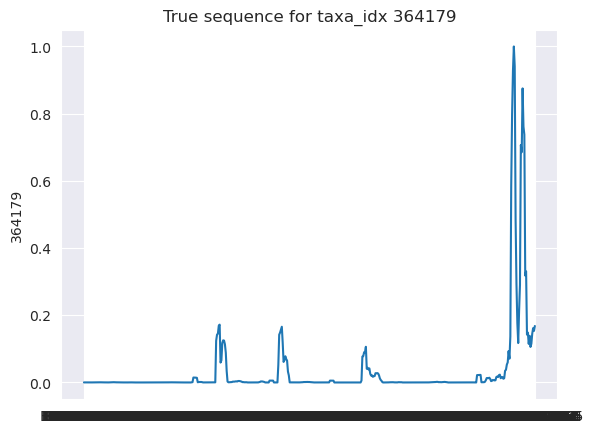

In [18]:
target_taxa = 364179

sns.lineplot(df[target_taxa])
plt.title(f"True sequence for taxa_idx {target_taxa}")
plt.show()

In [19]:
seq_length = 50
cutoff = 411

X_sequences, y_targets = preprocess(feats_df=df, seq_length=seq_length)

In [20]:
X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

Length of data: 516
Total sequences: 466
Train sequences: 411
Test sequences: 55


In [21]:
n_feats = len(df.columns)

In [136]:
reg = 1e-12
loss=mae_ignore_zeros

model = Sequential()
model.add(keras.Input(shape=(seq_length,n_feats)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(2048, activation="tanh", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_feats, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1024)              7483392   
                                                                 
 dense_21 (Dense)            (None, 2048)              2099200   
                                                                 
 dense_22 (Dense)            (None, 802)               1643298   
                                                                 
Total params: 11225890 (42.82 MB)
Trainable params: 11225890 (42.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [138]:
model.fit(x=X_sequences_train, y=y_targets_train, validation_split=0.05, epochs=1)

13/13 [==============================] - 1s 59ms/step - loss: 0.1064 - mae: 0.0698 - mape: 9895259.0000 - val_loss: 0.1252 - val_mae: 0.0929 - val_mape: 13612568.0000


In [139]:
y_pred = model.predict(X_sequences_test)

2/2 [==============================] - 0s 10ms/step


In [140]:
y_test_df = pd.DataFrame(y_targets_test)
y_pred_df = pd.DataFrame(y_pred)

In [141]:
y_test_df

,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,800,801
0,0.022843,0.111111,0.028571,0.000000,0.000000,0.219512,0.031579,0.694377,0.037386,0.013270,...,0.250000,0.265606,0.077670,0.117978,0.305556,0.000000,0.251813,0.002375,0.189394,0.302326
1,0.022843,0.111111,0.028571,0.000000,0.000000,0.219512,0.031579,0.623472,0.019149,0.012742,...,0.178571,0.222715,0.077670,0.106742,0.222222,0.000000,0.247618,0.000000,0.151515,0.235880
2,0.022843,0.111111,0.028571,0.000000,0.000000,0.219512,0.021053,0.613692,0.012158,0.014207,...,0.178571,0.255036,0.077670,0.095506,0.222222,0.000000,0.216683,0.000000,0.234848,0.481728
3,0.025381,0.000000,0.000000,0.000000,0.023622,0.024390,0.015789,0.168704,0.008207,0.010511,...,0.035714,0.142139,0.009709,0.033708,0.138889,0.000000,0.109017,0.000000,0.181818,0.385382
4,0.022843,0.055556,0.000000,0.000000,0.023622,0.170732,0.015789,0.166259,0.008207,0.004054,...,0.026786,0.089946,0.019417,0.011236,0.083333,0.000594,0.082847,0.000000,0.181818,0.338870
5,0.002538,0.055556,0.000000,0.000000,0.023622,0.170732,0.005263,0.031785,0.001520,0.004940,...,0.000000,0.089652,0.009709,0.011236,0.000000,0.000594,0.013512,0.000000,0.083333,0.335548
6,0.002538,0.055556,0.000000,0.000000,0.023622,0.170732,0.031579,0.031785,0.001520,0.007478,...,0.000000,0.100833,0.009709,0.011236,0.000000,0.000678,0.013512,0.000000,0.083333,0.335548
7,0.002538,0.055556,0.000000,0.081395,0.023622,0.170732,0.073684,0.031785,0.000608,0.006712,...,0.000000,0.037753,0.009709,0.011236,0.000000,0.000763,0.010454,0.000000,0.000000,0.049834
8,0.000000,0.055556,0.000000,0.081395,0.000000,0.170732,0.094737,0.031785,0.000000,0.006184,...,0.000000,0.070708,0.009709,0.000000,0.000000,0.000763,0.000000,0.066508,0.000000,0.003322
9,0.065990,0.000000,0.000000,0.081395,0.000000,0.000000,0.110526,0.244499,0.000000,0.006490,...,0.196429,0.127246,0.000000,0.000000,0.111111,0.000170,0.000000,0.168646,0.000000,0.000000


In [142]:
y_pred_df

,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,800,801
0,0.055678,0.093750,0.162571,0.093071,0.133825,0.185872,0.010735,0.018169,0.053756,0.000000,...,0.180135,0.224167,0.039606,0.065621,0.100492,0.044709,0.000000,0.000000,0.015099,0.207653
1,0.047052,0.093423,0.157825,0.085115,0.139187,0.193271,0.015050,0.025243,0.049604,0.000000,...,0.175935,0.207427,0.048597,0.062327,0.115263,0.053850,0.000000,0.000000,0.033556,0.208038
2,0.033506,0.087415,0.146166,0.070998,0.124738,0.173461,0.020510,0.034638,0.044990,0.000000,...,0.139168,0.160387,0.050252,0.051466,0.113317,0.047644,0.000000,0.000000,0.044969,0.190242
3,0.033382,0.083145,0.157132,0.071113,0.134318,0.161587,0.022343,0.041948,0.039474,0.000000,...,0.147661,0.174782,0.039887,0.061123,0.107330,0.044319,0.000000,0.000000,0.056084,0.195588
4,0.015343,0.066523,0.133840,0.053048,0.087098,0.088854,0.026498,0.049147,0.029549,0.000000,...,0.092698,0.144878,0.010170,0.033330,0.057817,0.007468,0.000000,0.000000,0.050722,0.164072
5,0.007772,0.058866,0.131359,0.040937,0.048631,0.098916,0.033049,0.022056,0.047608,0.000000,...,0.077273,0.122877,0.005606,0.012264,0.040124,0.000000,0.000000,0.000000,0.031305,0.165990
6,0.005293,0.043670,0.128490,0.029301,0.007609,0.073516,0.044342,0.010914,0.051830,0.000000,...,0.039375,0.107604,0.000000,0.000000,0.001027,0.000000,0.000000,0.000000,0.010473,0.162776
7,0.007616,0.039928,0.129375,0.027609,0.000000,0.072689,0.044883,0.007102,0.054366,0.000000,...,0.042929,0.123925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007358,0.163923
8,0.005206,0.038259,0.115208,0.021242,0.000000,0.068784,0.048084,0.001488,0.056994,0.000000,...,0.016628,0.096705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001226,0.147731
9,0.002853,0.035595,0.110148,0.014009,0.000000,0.075331,0.049222,0.000000,0.064893,0.000000,...,0.004060,0.082487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142465


In [143]:
non_predicted_cols = [col for col in y_pred_df.columns if all(y_pred_df[col] == 0.0)]
n_non_predicted_cols = len(non_predicted_cols)

print(f"Total taxa not predicted: {n_non_predicted_cols}, {(n_non_predicted_cols/len(y_test_df.columns)) * 100}% of all taxa")

Total taxa not predicted: 90, 11.221945137157107% of all taxa


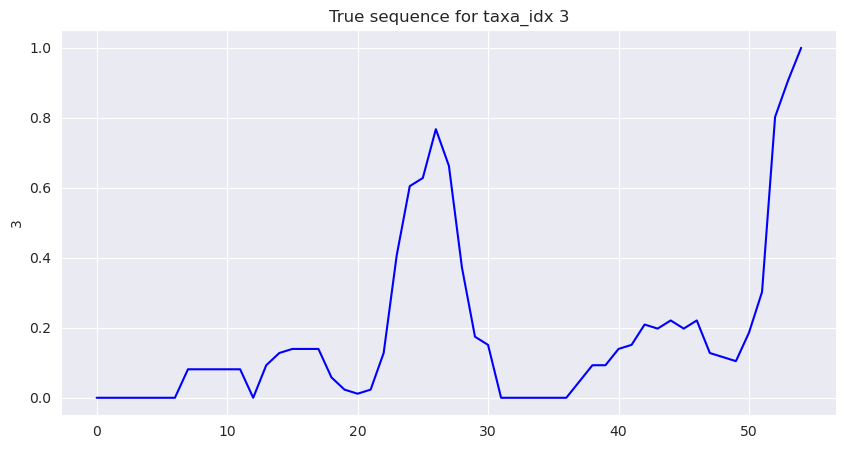

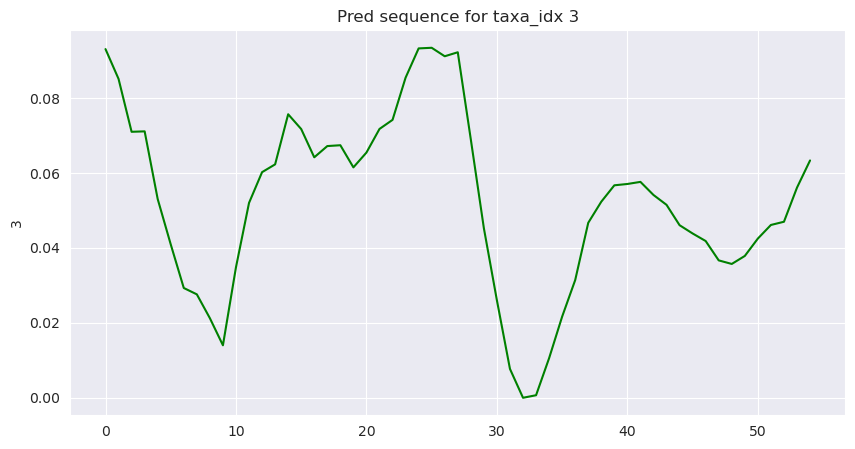

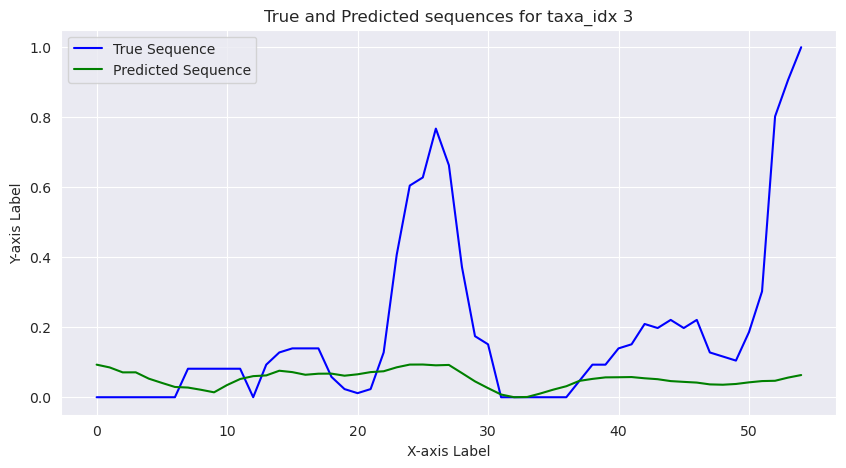

In [144]:
target_taxa = 3

figsize = (10,5)
true_colour = "blue"
pred_colour = "green"

plt.figure(figsize=figsize)
sns.lineplot(y_test_df[target_taxa], color=true_colour)
plt.title(f"True sequence for taxa_idx {target_taxa}")
plt.show()

plt.figure(figsize=figsize)
sns.lineplot(y_pred_df[target_taxa], color=pred_colour)
plt.title(f"Pred sequence for taxa_idx {target_taxa}")
plt.show()

plt.figure(figsize=figsize) 

sns.lineplot(data=y_test_df[target_taxa], label='True Sequence', color=true_colour)
sns.lineplot(data=y_pred_df[target_taxa], label='Predicted Sequence', color=pred_colour)

plt.title(f"True and Predicted sequences for taxa_idx {target_taxa}")
plt.xlabel('X-axis Label')  # Add your x-axis label here
plt.ylabel('Y-axis Label')  # Add your y-axis label here

# Add a legend to differentiate between true and predicted sequences
plt.legend()

plt.show()


In [145]:
def calculate_errors(y_pred_df, y_test_df):
    
    errors_df = []
    for col in y_pred_df.columns:
        errors = abs((y_test_df[col] - y_pred_df[col] ) / (y_test_df[col] + 1e-10))
        errors_df.append(errors)
        
    errors_df = pd.concat(errors_df, axis=1)
    
    return errors_df

In [146]:
errors_df = calculate_errors(y_pred_df, y_test_df)
errors_df.describe()


,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,800,801
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,3513230.158853,305676677.216768,317428459.428172,104702079.428841,133096578.314159,165421439.851667,90753718.582107,438364.524618,157089872.374089,1.000000,...,102549874.708626,96.364078,49146751.972534,72800794.295064,11082088.199009,44407626.012441,0.781818,0.490909,11534588.234607,49942698.243277
std,16674438.576267,320552490.942133,582046142.540104,237966220.627184,355658628.137666,374207861.765405,147617216.798991,3250992.206159,338374544.693541,0.000000,...,213285558.278069,329.626156,121542564.021217,187810014.085971,59868345.103605,133896279.139525,0.416818,0.504525,42868289.334290,259652577.266843
min,0.000000,0.000000,0.026660,0.000000,0.000000,0.041586,0.025768,0.262747,0.094661,1.000000,...,0.000000,0.007869,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022492
25%,0.396253,0.523683,0.305851,0.604894,0.341814,0.306915,0.672914,0.648699,1.000000,1.000000,...,0.279081,0.259702,0.357918,0.356296,0.275620,0.655896,0.999999,0.000000,0.380924,0.410329
50%,0.726996,194014906.883240,0.547996,0.810625,0.628984,0.505887,1.803321,0.930744,38.849512,1.000000,...,0.689375,0.386774,0.748947,0.727551,0.506797,0.999999,1.000000,0.000000,0.716348,0.641954
75%,1.035125,566843748.092651,4.606929,3.357317,0.906651,3.579809,169917196.035385,1.000000,136.137071,1.000000,...,5.795076,0.613688,1.465530,0.952393,0.736861,22.900654,1.000000,1.000000,0.906272,1.285343
max,109979286.789894,836709588.766098,1594896018.505096,930711627.006531,1391865164.041519,1796606332.063675,432721599.936485,24110004.305840,1226815804.839134,1.000000,...,772726759.314537,1629.532061,571343004.703522,752811580.896378,401238016.784191,538496822.118759,1.000000,1.000000,209132507.443428,1424651443.958282


In [169]:
def percentile_graph(errors_df, label, y_top_lim=3, step=0.1, x_percentile=None):
    
    # hardcoded stuff
    percentile_range = np.arange(0, 101)
    x_ticks_range = range(0, 110, 10)
    
    median_errors = errors_df.median()
    median_error_percentiles = np.percentile(median_errors, percentile_range)

    plt.figure(figsize=(8,6))
    sns.lineplot(median_error_percentiles)
    plt.title(f"Percentiles of median errors {label}")
    plt.xticks(x_ticks_range)
    plt.yticks(np.arange(0, float(y_top_lim + step), step))
    plt.ylim(0, y_top_lim)
    
    if x_percentile is not None:
        sns.lineplot([x_percentile for _ in range(len(percentile_range))], color="red") # the x percentile line
    
    plt.show()

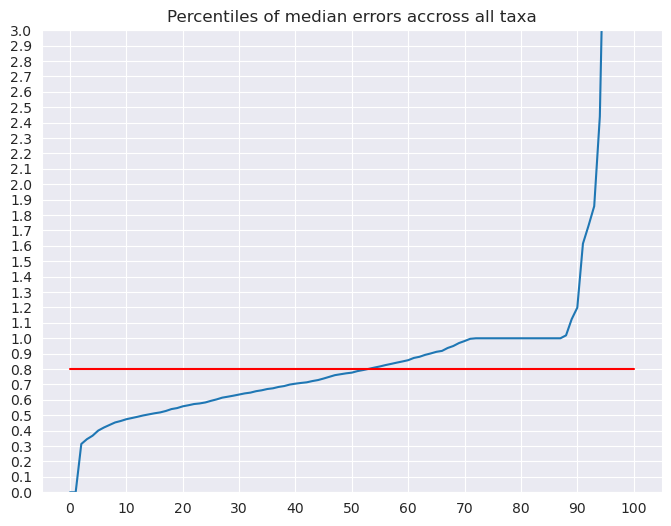

In [170]:
percentile_graph(errors_df, "accross all taxa", x_percentile=0.8)

In [149]:
only_predicted_errors = errors_df[errors_df.columns[~(errors_df.columns.isin(non_predicted_cols))]]

In [150]:
only_predicted_errors.describe()

,0,1,2,3,4,5,6,7,8,10,...,790,791,792,793,794,795,796,797,800,801
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,3513230.158853,305676677.216768,317428459.428172,104702079.428841,133096578.314159,165421439.851667,90753718.582107,438364.524618,157089872.374089,34887280.940395,...,63846954.996624,12.236089,102549874.708626,96.364078,49146751.972534,72800794.295064,11082088.199009,44407626.012441,11534588.234607,49942698.243277
std,16674438.576267,320552490.942133,582046142.540104,237966220.627184,355658628.137666,374207861.765405,147617216.798991,3250992.206159,338374544.693541,166052128.968770,...,197696049.376752,35.615384,213285558.278069,329.626156,121542564.021217,187810014.085971,59868345.103605,133896279.139525,42868289.334290,259652577.266843
min,0.000000,0.000000,0.026660,0.000000,0.000000,0.041586,0.025768,0.262747,0.094661,0.001439,...,0.005364,0.004307,0.000000,0.007869,0.000000,0.000000,0.000000,0.000000,0.000000,0.022492
25%,0.396253,0.523683,0.305851,0.604894,0.341814,0.306915,0.672914,0.648699,1.000000,0.460673,...,0.251854,0.231485,0.279081,0.259702,0.357918,0.356296,0.275620,0.655896,0.380924,0.410329
50%,0.726996,194014906.883240,0.547996,0.810625,0.628984,0.505887,1.803321,0.930744,38.849512,0.781627,...,0.418590,0.497944,0.689375,0.386774,0.748947,0.727551,0.506797,0.999999,0.716348,0.641954
75%,1.035125,566843748.092651,4.606929,3.357317,0.906651,3.579809,169917196.035385,1.000000,136.137071,1.447464,...,0.626280,0.660366,5.795076,0.613688,1.465530,0.952393,0.736861,22.900654,0.906272,1.285343
max,109979286.789894,836709588.766098,1594896018.505096,930711627.006531,1391865164.041519,1796606332.063675,432721599.936485,24110004.305840,1226815804.839134,1105609983.205795,...,1050781384.110451,148.391042,772726759.314537,1629.532061,571343004.703522,752811580.896378,401238016.784191,538496822.118759,209132507.443428,1424651443.958282


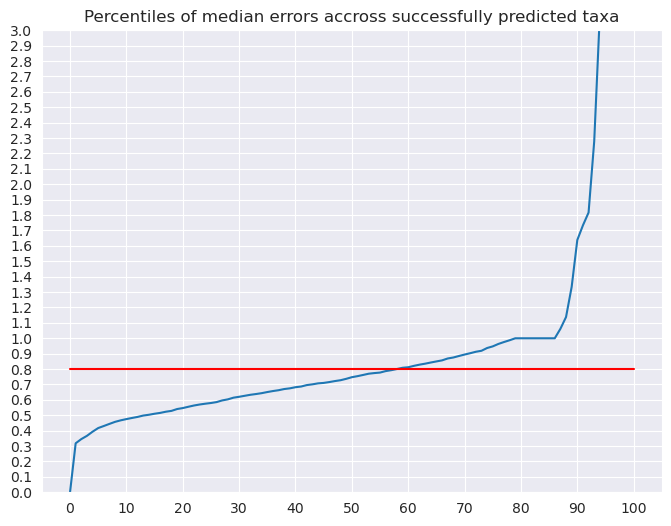

In [173]:
percentile_graph(only_predicted_errors, "accross successfully predicted taxa", x_percentile=0.8)